Напишите на Python реализацию как минимум одного алгоритма на выбор: любая на выбор цветовая обработка, перевод в другое цветовое пространство или фильтрация. Изображение выберите самостоятельно.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import imageio

In [2]:
img = imageio.imread('opensuse.jpeg')
img = img[:,:,0].astype(np.float32) / 255.
print(img.shape)

(200, 200)


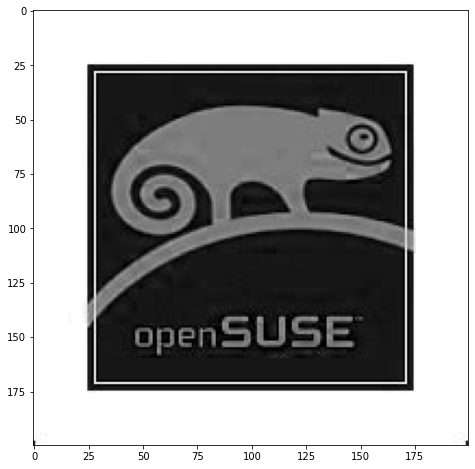

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')

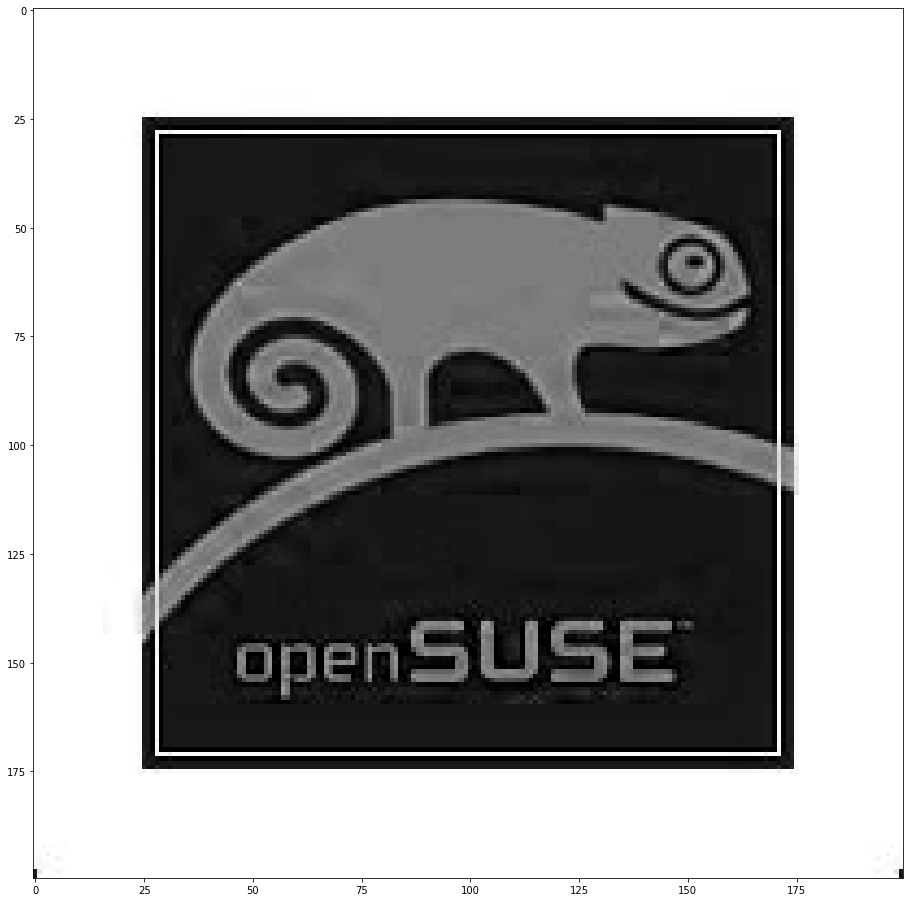

In [4]:
plt.figure(figsize=(16, 16))
plt.imshow(img, cmap='gray')

In [5]:
%%time
def get_filtered_img(img='',
                     box_blure=False,
                     win_size = (3, 3),
                     gussian_blur=False,
                     border_detector=True):
    # Box blur
    if box_blure:
        w = np.ones(win_size, dtype=np.float32)
        w = w / np.sum(w)
        
    # Gaussian blur
    elif gussian_blur:
        sigma = 3
        w = np.zeros(win_size, dtype=np.float32)
        for i in range(w.shape[0]):
            for j in range(w.shape[1]):
                w[i,j] = np.exp(-(i-w.shape[0]//2)**2 / sigma**2 / 2 
                                -(j-w.shape[1]//2)**2 / sigma**2 / 2)
        w = w / np.sum(w)
    
    if border_detector:
        vertical_filter = np.ones([3, 3])
        vertical_filter[:, 1] = 0
        vertical_filter[:, 2] = -1

        horizontal_filter = vertical_filter.T
        
    
    out_img = np.zeros(
            (img.shape[0] - vertical_filter.shape[0] + 1,
             img.shape[1] - vertical_filter.shape[1] + 1), 
             dtype=np.float32)

    for i in range(out_img.shape[0]):
        for j in range(out_img.shape[1]):
            x = img[i:i+vertical_filter.shape[0],
                    j:j+vertical_filter.shape[1]]
            
            if box_blure or gussian_blur:
                x_w = img[i:i+w.shape[0],
                          j:j+w.shape[1]]
                out_img[i,j] = np.sum(vertical_filter*x + horizontal_filter*x + x_w*w)
            else:
                out_img[i,j] = np.sum(vertical_filter*x + horizontal_filter*x)

    return out_img
        

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 11.4 µs


In [6]:
out_img0 = get_filtered_img(img = img, gussian_blur=True, border_detector=True, )

In [7]:
out_img1 = get_filtered_img(img = img, border_detector=True, )

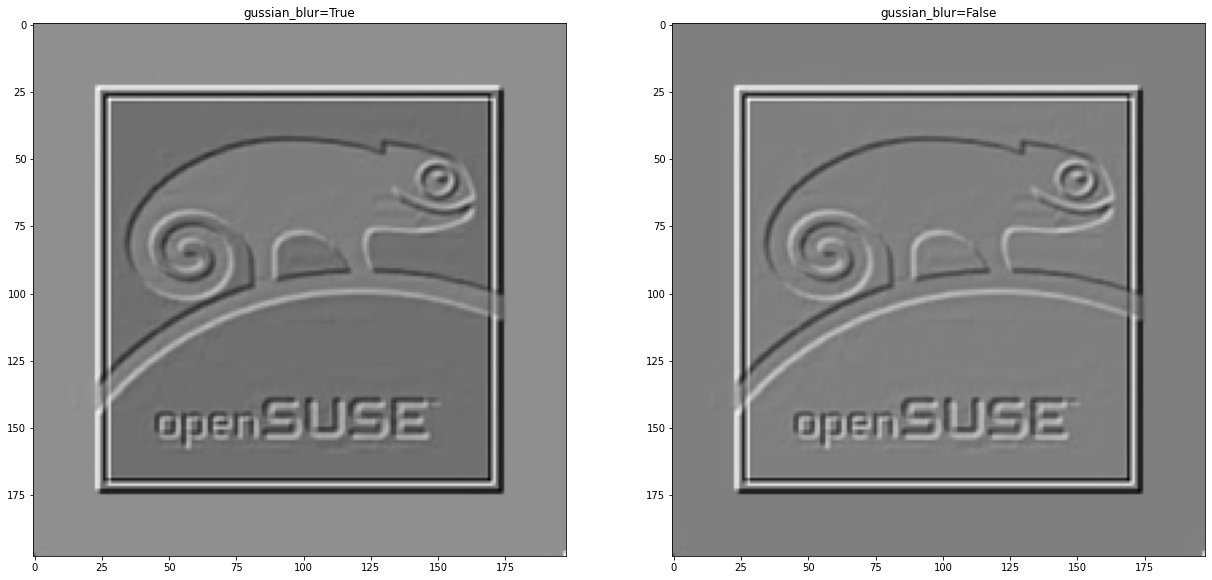

In [8]:
fig, axes = plt.subplots(1,2) 

axes[0].imshow(out_img0, cmap='gray')
axes[0].set_title('gussian_blur=True')

axes[1].imshow(out_img1, cmap='gray')
axes[1].set_title('gussian_blur=False')

fig.set_figwidth(21)    #  ширина и
fig.set_figheight(21)    #  высота "Figure"

plt.show()

### Негатив

In [25]:
def get_negativ_img(img):

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i,j][0] = 1 - img[i, j][0]
            img[i,j][1] = 1 - img[i, j][1]
            img[i,j][2] = 1 - img[i, j][2]
            
    return img


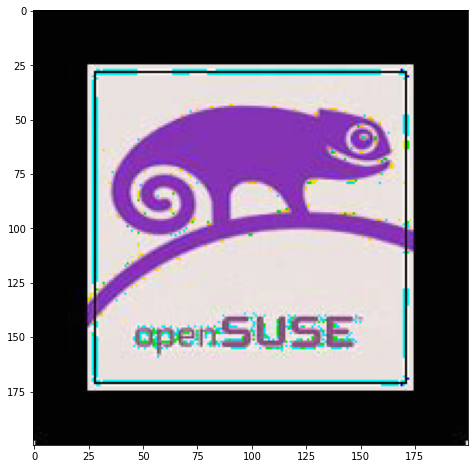

In [26]:
img = imageio.imread('opensuse.jpeg')
plt.figure(figsize=(8, 8))
plt.imshow(get_negativ_img(img))


## Перекодировка RGB - YUV

$$\text{Компоненты YUV определены на основе компонент RGB по следующим формулам:}\\
Y=K_R\cdot+(1-K_R-K_B)\cdot G+K_B\cdot B\\
U=B-Y\\
V=R-Y\\
\text{Обратное преоброзование в RGB:}\\
R=Y+V\\
G=Y-\frac{K_R\cdot V+K_B\cdot U}{1-K_R-K_B}\\
B=Y+U\\
$$

### Нормировака YUV (Формат YPbPr)

    Если принять, что компоненты RGB изменяются в диапазоне [0, A),
    тогда, по определению, компонента U изменяется в интервале [−(1 — KB) A, (1 — KB) A],
    а V в интервале [−(1 — KR) A, (1 — KR) A]. 

### Цифровое представление YUV. (Формат YCbCr)
    
    В основном, для цифрового формата данных используются целые неотрицательные числа степени 2. Чаще - 8 бит, 10 бит и так далее.
    Поскольку, U и V могут быть отрицательными, то для них вводят смещение - половина от уровней квантования (кодирования).
    Также для прореживания менее информативных компонент применяют пространственное кодирование, например YUYV или YUV422. 

Коэффициенты $K_R\;K_B$

В рекомендации BT.601 определены следующие значения для $K_R$ и $K_B$:

$${\begin{aligned}
K_{R}&=0.299\\
K_{B}&=0.114\\
\end{aligned}}
$$

Эти же значения используются для преобразования цветового пространства в YPbPr и JPEG (JFIF) ITU T-REC-T.871.

По рекомендации BT.709 определены значения $K_R$ и $K_B$:


$${\begin{aligned}
K_{R}&=0.2126\\
K_{B}&=0.0722\\
\end{aligned}}
$$

B рекомендации BT.2020

$${\begin{aligned}
K_{R}&=0.2627\\
K_{B}&=0.0593\\
\end{aligned}}
$$

При этом для сохранения постоянства яркости учитывают нелинейное соответствие RGB и яркости и вводят различные множители для отрицательных и положительных значений U и V. В традиционном варианте, с непостоянной яркостью, множители - постоянные величины. 

### Кодирование YUV в JPEG (T-REC-T.871)

В рекомендации T-REC-T.871 определены преобразования для представления YUV в цифровой форме YCbCr:

$$\begin{aligned}
Y&=0.299\cdot R+0.587\cdot G+0.114\cdot B\\
C_{B}&={\frac {1}{2}}\cdot {\frac {B-Y}{1-0.114}}+128\approx -0.1687\cdot R-0.3313\cdot G+0.5\cdot B+128\\
C_{R}&={\frac {1}{2}}\cdot {\frac {R-Y}{1-0.299}}+128\approx 0.5\cdot R-0.4187\cdot G-0.0813\cdot B+128\\
\end{aligned}
$$
По сути, с учётом смещения нуля это преобразование аналогично YPbPr - все компоненты занимают полный диапазон, доступный для данной разрядности данных.

Обратное преобразование в RGB:

$${\begin{aligned}
R&=Y+1.402\cdot (C_{R}-128)\\
G&=Y-\frac{(0.114\cdot 1.772\cdot (C_{B}-128)+0.299\cdot 1.402\cdot (C_{R}-128))}{0.587}\approx Y-0.3441\cdot (C_{B}-128)-0.7141\cdot (C_{R}-128)\\
B&=Y+1.772\cdot (C_{B}-128)\\
\end{aligned}}
$$

При этом каждую вычисленную компоненту следует привести к [0,255] - отсечь. 

### Кодирование YUV в телевизионных стандартах

Преобразование для BT.601 YCbCr осуществляется по следующим формулам:

$${\begin{aligned}
Y&=0,299\times R+0,587\times G+0,114\times B\\
U&=-0,14713\times R-0,28886\times G+0,436\times B+128\\
V&=0,615\times R-0,51499\times G-0,10001\times B+128\end{aligned}}
$$

Обратное преобразование для BT.601 в RGB YCbCr из RGB осуществляется по следующим формулам:

$${\begin{aligned}
R&=Y+1,13983\times (V-128)\\
G&=Y-0,39465\times (U-128)-0,58060\times (V-128)\\
B&=Y+2,03211\times (U-128)\\
\end{aligned}}
$$

где R, G, B — соответственно, цифровое представление интенсивности цветов красного, зелёного и синего; Y — яркостная составляющая; U и V — цветоразностные составляющие. По BT.601 и BT.709 цифровое представление интенсивности цветов означает, что исходную величину интенсивности, прошедшую предварительную гамма-коррекцию и находящуюся в диапазоне [0,1], следует умножить на 219 и прибавить 16, например {R = 219 R' + 16}. 

**Формулы и выдержки взяты со страницы википедии:**

**https://ru.wikipedia.org/wiki/YUV**

In [ ]:
def get_sepia_img(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            r = img[i, j][0]
            g = img[i, j][1]
            b = img[i, j][2]
        
            tr = 0.393*r + 0.769*g + 0.189*b
            tg = 0.349*r + 0.686*g + 0.168*b
            tb = 0.272*r + 0.534*g + 0.131*b
        
            img[i, j] = [tr if tr < 1 else 1,
                         tg if tr < 1 else 1,
                         tb if tr < 1 else 1]

    return img




img = imageio.imread('opensuse.jpeg')
plt.figure(figsize=(8, 8))
plt.imshow(get_sepia_img(img))


Преоброзование в сепию:
$$
tr = 0.393\cdot R + 0.769\cdot G + 0.189\cdot B\\
tg = 0.349\cdot R + 0.686\cdot G + 0.168\cdot B\\
tb = 0.272\cdot R + 0.534\cdot G + 0.131\cdot B\\
$$
<a href='https://coderoad.ru/59143570/%D0%9A%D0%B0%D0%BA%D0%BE%D0%B2%D0%B0-%D1%84%D0%BE%D1%80%D0%BC%D1%83%D0%BB%D0%B0-%D0%B4%D0%BB%D1%8F-%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F-%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F-RGB-%D0%B2-%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80-%D1%81%D0%B5%D0%BF%D0%B8%D0%B8'>https://coderoad.ru/59143570/Какова-формула-для-преобразования-изображения-RGB-в-фильтр-сепии</a>

In [ ]:
def get_sepia_img(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            r = img[i, j][0]
            g = img[i, j][1]
            b = img[i, j][2]
        
            tr = 0.393*r + 0.769*g + 0.189*b
            tg = 0.349*r + 0.686*g + 0.168*b
            tb = 0.272*r + 0.534*g + 0.131*b
        
            img[i, j] = [tr if tr < 1 else 1,
                         tg if tr < 1 else 1,
                         tb if tr < 1 else 1]

    return img


In [ ]:
img = imageio.imread('opensuse.jpeg')
plt.figure(figsize=(8, 8))
plt.imshow(get_sepia_img(img))
